In [1]:
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

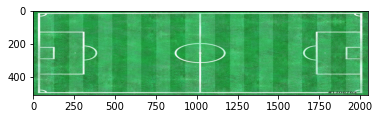

(512, 2048, 3)


In [2]:
img = cv2.imread(r'photo.png')
plt.imshow(img)
plt.show()
print(img.shape)

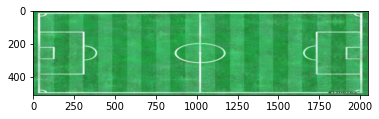

In [3]:
ksize = (5, 5)  # Size of the blur kernel, larger values produce stronger blur
blurred_image = cv2.blur(img, ksize)
plt.imshow(blurred_image)
plt.show()

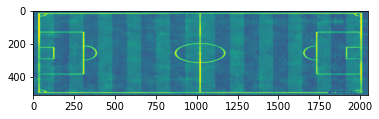

In [4]:
gray_image = cv2.cvtColor(blurred_image , cv2.COLOR_BGRA2GRAY)
plt.imshow(gray_image)
plt.show()

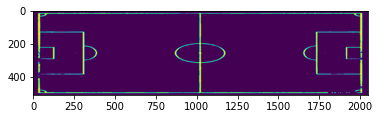

In [5]:
threshold_value = 200  # Adjust this threshold value as needed
max_value = 255  # Maximum value assigned to pixels exceeding the threshold
_, thresholded_image = cv2.threshold(gray_image, threshold_value, max_value, cv2.THRESH_BINARY)
plt.imshow(thresholded_image)
plt.show()

In [6]:
KEEPER = [(0,448),(1552,2048)]
DEFENCE_FORWARD = [(448,750),(1250,1552)]
MIDD = [(750,1250)]
SIZE = 255

In [7]:
def Generator(image):
    gray = image.copy()
    zero_point = random.randint(0, image.shape[1]-SIZE+1)
    keeper = (0,0)
    deffense_forward = (0,0)
    midd = (0,0)
    for i in KEEPER:
        tmp=(0,0)
        if i[1] <= zero_point +SIZE and i[1] >= zero_point:
            tmp = (0,i[1]-zero_point)
        elif i[0] <= zero_point +SIZE and i[0] >= zero_point:
            tmp = (i[0]-zero_point, SIZE)
        elif i[0] <= zero_point and i[1] >= zero_point +SIZE:
            tmp = (0, SIZE)
        if (keeper[1] - keeper[0]) < (tmp[1] - tmp[0]):
            keeper = tmp
    for i in DEFENCE_FORWARD:
        tmp=(0,0)
        if i[1] <= zero_point +SIZE and i[1] >= zero_point:
            tmp = (0,i[1]-zero_point)
        elif i[0] <= zero_point +SIZE and i[0] >= zero_point:
            tmp = (i[0]-zero_point, SIZE)
        elif i[0] <= zero_point and i[1] >= zero_point +SIZE:
            tmp = (0, SIZE)
        if (deffense_forward[1] - deffense_forward[0]) < (tmp[1] - tmp[0]):
            deffense_forward = tmp
    for i in MIDD:
        tmp=(0,0)
        if i[1] <= zero_point +SIZE and i[1] >= zero_point:
            tmp = (0,i[1]-zero_point)
        elif i[0] <= zero_point +SIZE and i[0] >= zero_point:
            tmp = (i[0]-zero_point, SIZE)
        elif i[0] <= zero_point and i[1] >= zero_point +SIZE:
            tmp = (0, SIZE)
        if (midd[1] - midd[0]) < (tmp[1] - tmp[0]):
            midd = tmp
    output = [(keeper[1]-keeper[0])/(SIZE+1),(deffense_forward[1]-deffense_forward[0])/(SIZE+1),(midd[1]-midd[0])/(SIZE+1)]
    max = 0.0
    max_index = 0
    for i in range(len(output)):
        if output[i] > max:
            max = output[i]
            max_index = i
        output[i] = 0
    output[max_index] = 1
    return gray[:,zero_point:zero_point+SIZE+1] , output

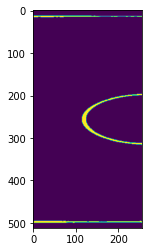

(512, 256)
[0, 0, 1]


In [8]:
image,output1 = Generator(thresholded_image)
plt.imshow(image)
plt.show()
print(image.shape)
print(output1)

In [9]:
def Augmentation(image):
    images = []
    angle_range = 20  # rotate by +/- 30 degrees
    # Generate 10 augmented images
    for i in range(10):
        # Generate a random rotation angle
        angle = random.uniform(-angle_range, angle_range)
        
        # Define the transformation matrix
        rows, cols = image.shape[:2]
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        
        # Apply the transformation
        dst = cv2.warpAffine(image, M, (cols, rows), borderMode = cv2.BORDER_CONSTANT, borderValue= random.randint(0, 255))
        for j in range(10):
            position = (random.randint(0, 400),random.randint(0, SIZE-160))
            dst[position[0]:position[0]+15,position[1]:position[1]+15] = random.randint(0, 255)
        
        images.append(dst)
    return images

In [10]:
def Generate_data_for_model(image,training_size,test_size):
    x_train,y_train1 = [],[]
    for i in range(int(training_size/10)):
        img1,output1 = Generator(image)
        tmp = Augmentation(img1)
        for j in tmp:
            j = j.astype('float32')
            j /= 255.0  
            x_train.append(j)
            y_train1.append(output1)

    x_test,y_test1  = [],[]
    for i in range(int(test_size/10)):
        img1,output1 = Generator(image)
        tmp = Augmentation(img1)
        for j in tmp:
            j = j.astype('float32')
            j /= 255.0  
            x_test.append(j)#.reshape( 512, 512))
            y_test1.append(output1)

    return x_train,y_train1,x_test,y_test1


In [11]:
x_train,y_train,x_test,y_test = Generate_data_for_model(thresholded_image,100,20)


In [12]:
# Define the model architecture
model1 = tf.keras.Sequential()
model1.add(layers.Reshape((512, 256, 1), input_shape=(512, 256)))  # Add a reshape layer for gray-scale input
model1.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(3, activation='softmax'))

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the model

# Print the model summary
model1.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 512, 256, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 510, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 62, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 60, 128)      7

In [13]:
# epochs_num = 10
# history1 = model1.fit(
#     x_train, y_train1,
#     epochs=epochs_num,
#     validation_data=(x_test, y_test1)
# )

In [14]:
# plt.plot(history1.history['accuracy'])
# plt.plot(history1.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

In [15]:
#model1.save('model-1-'+str(epochs_num)+'.h5')


In [16]:
def Generate_data_for_model_transfer(images,outputs,training_size,test_size):
    x_train,y_train  = [],[]
    for count in range(len(images)):
        image = images[count]
        output = outputs[count]
        for i in range(int(training_size/10)):
            tmp = Augmentation(image)
            for j in tmp:
                j = j.astype('float32')
                j /= 255.0    
                x_train.append(j)
                y_train.append(output)
        x_test,y_test  = [],[]
        for i in range(int(test_size/10)):
            tmp = Augmentation(image)
            for j in tmp:
                j = j.astype('float32')
                j /= 255.0  
                x_test.append(j)
                y_test.append(output)
    return x_train,y_train,x_test,y_test

In [17]:

#model = load_model('model-1-'+str(epochs_num)+'.h5')

In [18]:
def two_point_threshold(gray_image):
    lower_threshold = 160
    upper_threshold = 180
    max_value = 255

    # Create a mask of pixels within the desired range
    mask = cv2.inRange(gray_image, lower_threshold, upper_threshold)

    # Apply the mask to set the pixels within the range to 255 and rest to 0
    result = np.zeros_like(gray_image)
    result[mask == 255] = max_value
    ksize = (3, 3)  # Size of the blur kernel, larger values produce stronger blur
    blurred_image = cv2.blur(result, ksize)
    return blurred_image

In [19]:
def extract_green_floor(image):
        # Convert the image to the HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    ## mask of green (36,25,25) ~ (86, 255,255)
    # mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
    mask = cv2.inRange(hsv, (36, 25, 25), (70, 255,255))

    ## slice the green
    imask = mask>0
    green = np.zeros_like(image, np.uint8)
    green[imask] = image[imask]


    return green

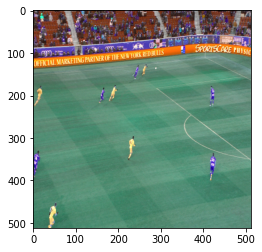

In [20]:

img_test = cv2.imread(r'transfere/57.jpg')
img_test = cv2.resize(img_test,(512,512))

plt.imshow(img_test)
plt.show()


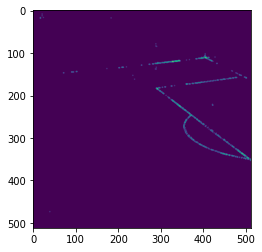

In [21]:
images = []
outputs = []
result_green = extract_green_floor(img_test)

gray = cv2.cvtColor(result_green,cv2.COLOR_BGR2GRAY)

gray = two_point_threshold(gray)
plt.imshow(gray)
plt.show()
images.append(gray[:,:256])
outputs.append([0,1,0])
images.append(gray[:,256:])
outputs.append([1,0,0])

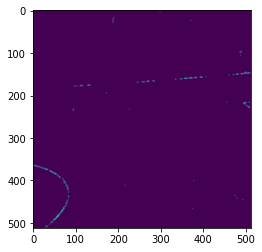

In [22]:
img_test = cv2.imread(r'transfere/6.jpg')
img_test = cv2.resize(img_test,(512,512))
result_green = extract_green_floor(img_test)

gray = cv2.cvtColor(result_green,cv2.COLOR_BGR2GRAY)

gray = two_point_threshold(gray)
plt.imshow(gray)
plt.show()

images.append(gray[:,:256])
outputs.append([0,0,1])
images.append(gray[:,256:])
outputs.append([0,1,0])

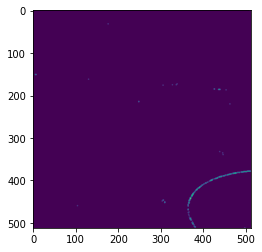

In [23]:
img_test = cv2.imread(r'transfere/94.jpg')
img_test = cv2.resize(img_test,(512,512))

result_green = extract_green_floor(img_test)

gray = cv2.cvtColor(result_green,cv2.COLOR_BGR2GRAY)

gray = two_point_threshold(gray)
plt.imshow(gray)
plt.show()

images.append(gray[:,:256])
outputs.append([0,1,0])
images.append(gray[:,256:])
outputs.append([0,0,1])

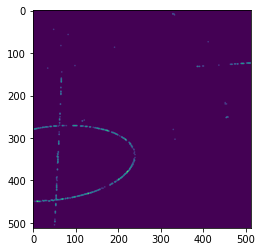

In [24]:
img_test = cv2.imread(r'transfere/492.jpg')
img_test = cv2.resize(img_test,(512,512))

result_green = extract_green_floor(img_test)

gray = cv2.cvtColor(result_green,cv2.COLOR_BGR2GRAY)

gray = two_point_threshold(gray)
plt.imshow(gray)
plt.show()

images.append(gray[:,:256])
outputs.append([0,0,1])
images.append(gray[:,256:])
outputs.append([0,1,0])

In [25]:
x_train1,y_train1,x_test1,y_test1 = Generate_data_for_model_transfer(images,outputs,50,10)
x_train2 = x_train + images + x_train1 
y_train2 = y_train + outputs + y_train1
x_test2 = x_test1 + x_test
y_test2 = y_test1 + y_test
x_train2 = np.array(x_train)
y_train2 = np.array(y_train)
x_test2 = np.array(x_test)
y_test2 = np.array(y_test)
shuffle_indices = np.random.permutation(len(x_train))
x_train2 = x_train2[shuffle_indices]
y_train2 = y_train2[shuffle_indices]


In [26]:
epochs_num = 5
history = model1.fit(
    x_train2, y_train2,
    epochs=epochs_num,
    validation_data=(x_test2, y_test2)
)

Epoch 1/5
4/4 [==============================] - 16s 3s/step - loss: 1.3519 - accuracy: 0.4900 - val_loss: 0.5284 - val_accuracy: 0.9000
Epoch 2/5
4/4 [==============================] - 14s 3s/step - loss: 0.3355 - accuracy: 0.9300 - val_loss: 0.3780 - val_accuracy: 0.9000
Epoch 3/5
4/4 [==============================] - 14s 3s/step - loss: 0.1227 - accuracy: 0.9900 - val_loss: 0.1356 - val_accuracy: 1.0000
Epoch 4/5
4/4 [==============================] - 14s 3s/step - loss: 0.0236 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/5
4/4 [==============================] - 14s 3s/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.9806e-05 - val_accuracy: 1.0000


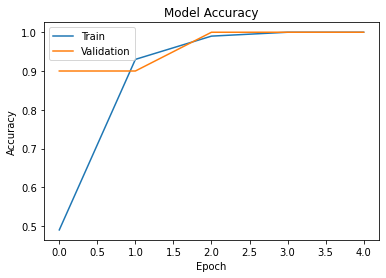

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [28]:
print(x_test[1].reshape(1, 512, 256))
y_pred_classes = np.argmax(model1.predict(x_train[20].reshape((1, 512, 256))), axis=1)
print(y_pred_classes)
print(y_train[20])

[[[0.12156863 0.12156863 0.12156863 ... 0.12156863 0.12156863 0.12156863]
  [0.12156863 0.12156863 0.12156863 ... 0.12156863 0.12156863 0.12156863]
  [0.12156863 0.12156863 0.12156863 ... 0.12156863 0.12156863 0.12156863]
  ...
  [0.12156863 0.12156863 0.12156863 ... 0.12156863 0.12156863 0.12156863]
  [0.12156863 0.12156863 0.12156863 ... 0.12156863 0.12156863 0.12156863]
  [0.12156863 0.12156863 0.12156863 ... 0.12156863 0.12156863 0.12156863]]]
1/1 [==============================] - 0s 195ms/step
[1]
[0, 1, 0]


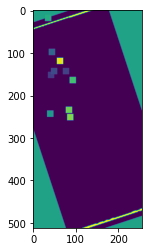

[0, 1, 0]


In [29]:
plt.imshow(x_train[20])
plt.show()
print(y_train[20])

In [30]:
model1.save('model-1-transformed-'+str(epochs_num)+'.h5')

In [31]:
images_test = []
outputs_test = []
img_test = cv2.imread(r'transfere/507.jpg')
img_test = cv2.resize(img_test,(512,512))

result_green = extract_green_floor(img_test)
gray = cv2.cvtColor(result_green,cv2.COLOR_BGR2GRAY)
gray = two_point_threshold(gray)

images_test.append(gray[:,:256])
outputs_test.append([0,1,0])
images_test.append(gray[:,256:])
outputs_test.append([0,1,0])

In [34]:
x_train,y_train,x_test,y_test = Generate_data_for_model_transfer(images_test,outputs_test,100,20)
x_train = np.array(x_train)
y_train = np.array(y_train)
print(model1.evaluate(x_train,y_train))

7/7 [==============================] - 6s 850ms/step - loss: 1.1488 - accuracy: 0.6150
[1.1487863063812256, 0.6150000095367432]
